In [4]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, random
import optax
import equinox as eqx
import matplotlib.pyplot as plt
from typing import List

In [5]:
#the first thing jax does differently is PRD
#we can create 'random' but fully repeatable experiemnts
#we generate a key, then we split it for each call.
#this split is you can simply replace the 0 with a wall clock call for "true determism"

#lets create 4 news keys (5 total)
key = jax.random.PRNGKey(0)
key, trainkey, testkey, noisekey1, noisekey2 = jax.random.split(key,5)

#pick our number of training and test samples
num_train = 5000
num_test = 2000

#get some random training points
train_data = jax.random.uniform(trainkey, (num_train,1), minval=-3*jnp.pi, maxval=3*jnp.pi)
test_data = jax.random.uniform(testkey, (num_test,1), minval=-10*jnp.pi, maxval=10*jnp.pi)

#compute our random target points
train_target = jnp.sin(train_data)
test_target = jnp.sin(test_data)
train_target_noisy = train_target + jax.random.normal(noisekey1, (num_train,1))*0.1
test_target_noisy = test_target + jax.random.normal(noisekey2, (num_test,1))*0.1

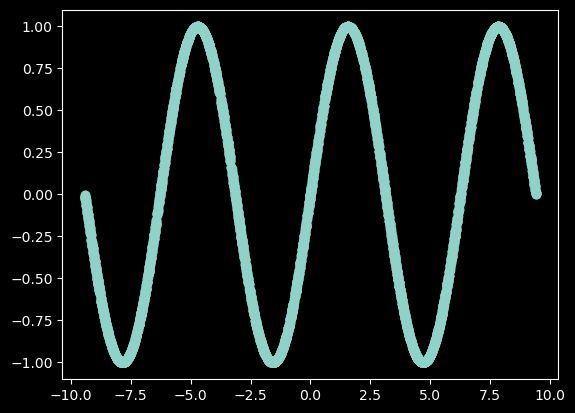

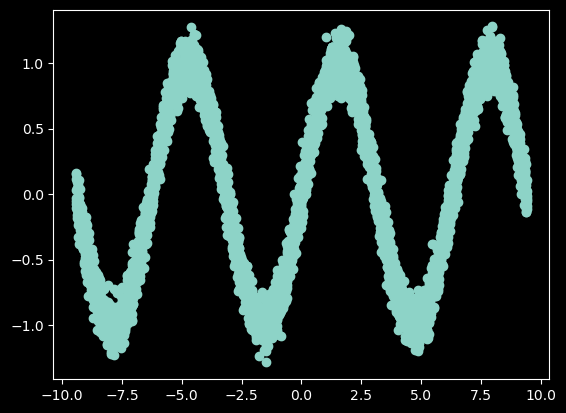

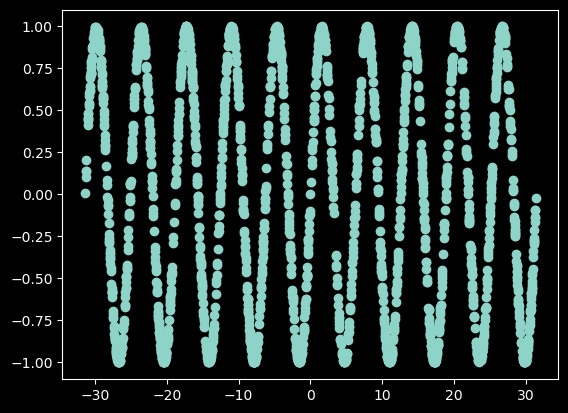

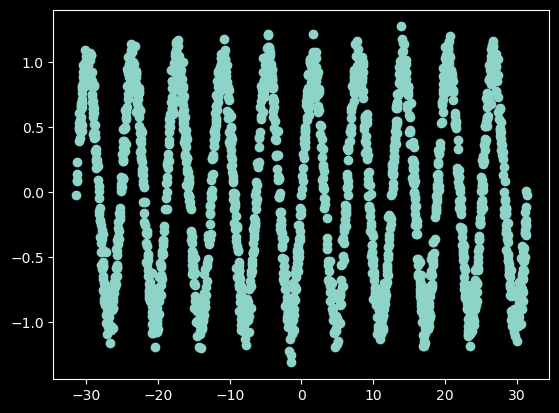

In [ ]:
#plot to see what they look like
plt.scatter(train_data,train_target)
plt.show()
plt.scatter(train_data,train_target_noisy)
plt.show()
plt.scatter(test_data,test_target)
plt.show()
plt.scatter(test_data,test_target_noisy)
plt.show()

In [7]:
#define a simple feed forward neural network
#the input and output will be size 1
#we want 3 hidden layers of size 10
architecture = [1,10,10,10,1]

#we are going to use the following nice trick for defining our network
#zip does what it says, zips things into a tuple
#we then take the first 4 and the last 4 of layers and combine them
#so we get (1,10), (10,10) ... (10,1)
#that is exactly the sizing we want for each of our layers
for (f_in,f_out) in zip(architecture[:-1], architecture[1:]):
    print(f_in,f_out)

1 10
10 10
10 10
10 1


In [21]:
#explicit model relying on a linear layer
class simpleModel(eqx.Module):
    #what is in our model? a stack of linear layers
    #we don't know how many, so lets just specify it as a list of them
    layers: List[eqx.nn.Linear]
    #we need an initialization method
    #what do we want
    #a prd key for initialization L R^in -> R^out: W(in)+b
    #and we need our layers.
    def __init__(self, architecture, key):
        self.layers = []
        for (f_in, f_out) in zip(architecture[:-1], architecture[1:]):
            key, subkey = jax.random.split(key)
            self.layers.append(
                eqx.nn.Linear(
                    f_in,
                    f_out,
                    use_bias = True,
                    key = subkey
                )
            )
    #now we need a way to call the neural network
    #we pass the key even if it isn't being used by convention
    def __call__(self, x):
        a = x
        for layer in self.layers[:-1]:
            a = jax.nn.sigmoid(layer(a))
        a = self.layers[-1](a)
        return a

#lets create our first model by calling this class
model = simpleModel(architecture, key)


In [22]:
#lets try caling our nice model
model(1)

ValueError: matmul input operand 1 must have ndim at least 1, but it has ndim 0

In [23]:
#and it immediately broke!
#why?
#matmul input operand 1 must have ndim at least 1, but it has ndim 0
#our model takes a "scalar" input but it really wants an R^1 vector
#when we pass it a raw scalar it will explode despite being equivalent mathematically
#this is because the scalar and R^1 vectors are distinct data types
#so we need to turnt his scalar into a R^1 vector
print(jnp.array(1.0))
print(jnp.array([1.0]))
#the second one is the form we want, and so we can use it in our model
model(jnp.array([1]))

1.0
[1.]


Array([0.593246], dtype=float32)

In [24]:
#ok so now we can toss in our data to see what it looks like on an untrained network
#model(train_data,key)
print(jnp.shape(train_data))

(5000, 1)


In [14]:
model(train_data)

TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (5000,).

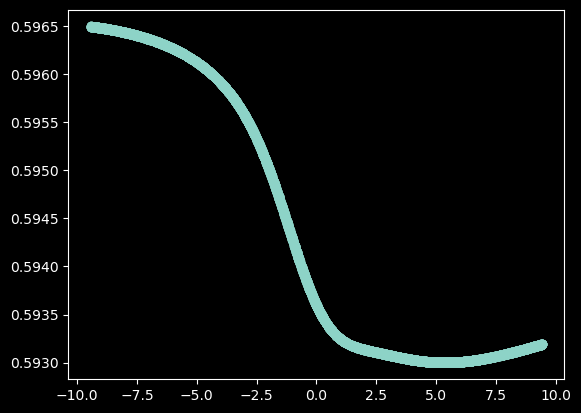

In [25]:
#and it expoded again
#you might guess the reason for this, our dimensions aren't right again
#the network wants an R^1 vector
#we instead gave it a "batch" of 5000 R^1 vectors
#that is R^5000, giving us the error
#dot_general requires contracting dimensions to have the same shape, got (1,) and (5000,).
#how do we fix this? using JAX's vmap command
vecmodel = jax.vmap(model, in_axes = 0)
plt.scatter(train_data, vecmodel(train_data))

In [26]:
class simpleMLP(eqx.Module):
    layer: eqx.nn.MLP

    def __init__(self, key, f_in, f_out, f_width, f_hidden, activation = jax.nn.sigmoid):
        self.layer = eqx.nn.MLP(
            f_in,
            f_out,
            f_width,
            f_hidden,
            activation = activation,
            use_bias=True,
            key = key)
    def __call__(self, x):
        a = x
        a = self.layer(a)
        return a


In [27]:
model1key, key = jax.random.split(key)
model1 = simpleMLP(model1key, 1, 1, 10, 3)

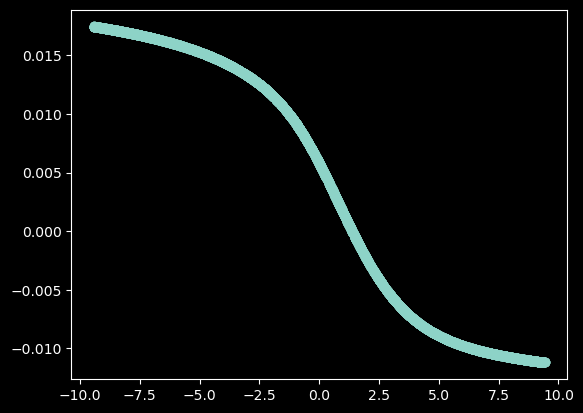

In [28]:
plt.scatter(train_data, jax.vmap(model1)(train_data))

In [29]:
import optax



In [30]:
# Define loss function
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss
# Initialize optimizer
learning_rate = 3e-4
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(eqx.filter(model1, eqx.is_array))

# Define a single training step
@eqx.filter_jit
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn, has_aux=False)(model, x, y)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

In [31]:
# Training loop
num_epochs = 25000
for epoch in range(num_epochs):
    model1, opt_state, train_loss = make_step(model1, opt_state, train_data, train_target)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {train_loss}")

Epoch 0, Loss: 0.500878632068634
Epoch 100, Loss: 0.49697694182395935
Epoch 200, Loss: 0.4929559826850891
Epoch 300, Loss: 0.4856385588645935
Epoch 400, Loss: 0.4770214855670929
Epoch 500, Loss: 0.47290048003196716
Epoch 600, Loss: 0.4715293347835541
Epoch 700, Loss: 0.4704967141151428
Epoch 800, Loss: 0.46956518292427063
Epoch 900, Loss: 0.46868276596069336
Epoch 1000, Loss: 0.4678078591823578
Epoch 1100, Loss: 0.46689262986183167
Epoch 1200, Loss: 0.4658602476119995
Epoch 1300, Loss: 0.464555948972702
Epoch 1400, Loss: 0.46263861656188965
Epoch 1500, Loss: 0.45936596393585205
Epoch 1600, Loss: 0.45351454615592957
Epoch 1700, Loss: 0.44365736842155457
Epoch 1800, Loss: 0.4286669194698334
Epoch 1900, Loss: 0.4082478880882263
Epoch 2000, Loss: 0.38250792026519775
Epoch 2100, Loss: 0.35160234570503235
Epoch 2200, Loss: 0.317095011472702
Epoch 2300, Loss: 0.2820289134979248
Epoch 2400, Loss: 0.24977143108844757
Epoch 2500, Loss: 0.2224116325378418
Epoch 2600, Loss: 0.20075680315494537
Epo

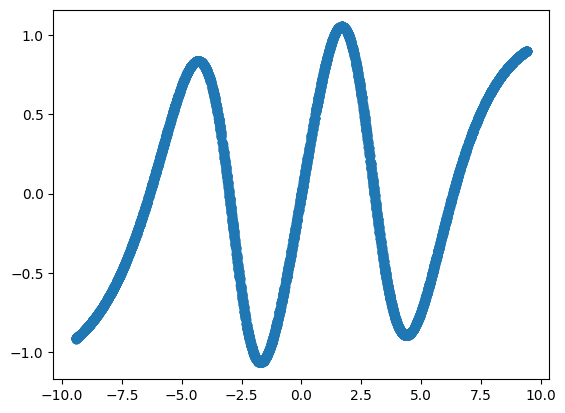

In [ ]:
plt.scatter(train_data, jax.vmap(model1)(train_data))